# Chapter 3 Time-dependent Differential Equation


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy
from scipy import sparse
from scipy.sparse import linalg
from mpl_toolkits.mplot3d import Axes3D
import Utils
import time

In [4]:
import scipy.optimize


def Explicit_Euler(u0, T, N, d, fhandle):
    dt = T / N
    u = np.zeros((d, N + 1))
    t = np.linspace(0, T, N + 1)
    u[:, 0] = u0
    un = u0
    for n in range(N):
        un = un + dt * fhandle(un)
        u[:, n + 1] = un
    return t, u

def Implicit_Euler(u0, T, N, d, fhandle):
    dt = T / N
    u = np.zeros((d, N + 1))
    t = np.linspace(0, T, N + 1)
    u[:, 0] = u0
    un = u0
    impeuler = lambda u: u - un - dt * fhandle(u)
    for n in range(N):
        un = scipy.optimize.fsolve(impeuler, un, xtol=dt**2)
        u[:, n+1] = un
    return t, u



Population Model

Elapsed time  0.5379548072814941


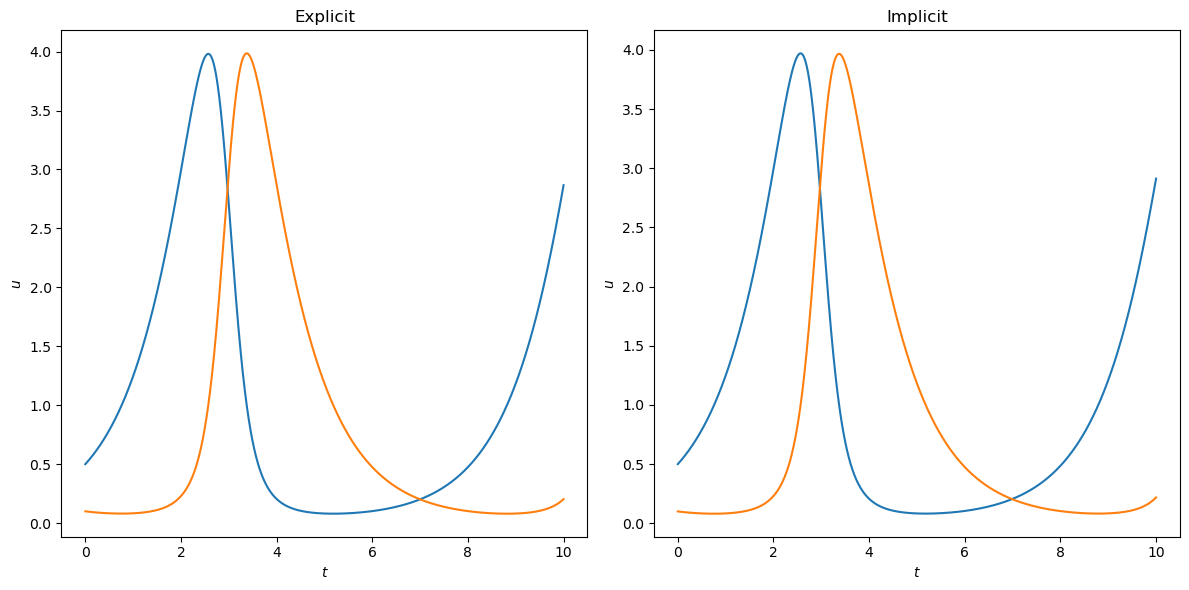

In [5]:
def f(u):
    return np.array([u[0]*(1-u[1]), u[1]*(u[0]-1)])
u0=[0.5,0.1]; T=10; N=int(1e4); d=2;

start=time.time()
[t1, u1] = Explicit_Euler(u0, T, N, d, f)
[t2, u2] = Implicit_Euler(u0, T, N, d, f)
print("Elapsed time ", time.time()-start)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(t1, u1[0, :])
ax1.plot(t1, u1[1, :])
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$u$')
ax1.set_title('Explicit')

ax2.plot(t2, u2[0, :])
ax2.plot(t2, u2[1, :])
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$u$')
ax2.set_title('Implicit')

plt.tight_layout()
plt.show()


semi-implicit Euler and FDM

In [6]:
def pde_fdm(u0, T, a, N, J, epsilon, fhandle, bctype):
    Dt=T / N;     
    t=np.linspace(0,T,N+1)
    h=a / J
    # set matrix A according to boundary conditions
    e=np.ones((J + 1,1))
    A=scipy.sparse.diags([-1,2,-1],[-1,0,1], shape=(J+1,J+1), format='csc')
    if 'd' == bctype.lower():
        ind=np.arange(1,J)
        A = A[:, ind]
        A = A[ind, :]
    else:
        if 'p' == bctype.lower():
            ind = np.arange(0,J)
            A = A[:,ind]; A = A[ind,:]
            A[1,-1] = -1; A[-1,1] = -1
        else:
            if 'n' == bctype.lower():
                ind=np.arange(0,J + 1)
                A[0,1] = -2; A[-1,-2] = -2 
    EE=scipy.sparse.identity(ind.size,format='csc') + (Dt * epsilon/h**2) * A 
    ut=np.zeros((J + 1,t.size)) # initialize vectors
    ut[:,0]=u0; u_n=u0[ind] # set initial condition
    #
    EEinv=sparse.linalg.factorized(EE)
    #
    for k in range(N): # time loop
        fu=fhandle(u_n) # evaluate f(u_n)
        u_new=EEinv(u_n + Dt * fu) # linear solve for EE
        ut[ind,k + 1]=u_new
        u_n=u_new
    if bctype.lower() == 'p':
        ut[-1,:]=ut[0,:] # correct for periodic case  
    return t,ut

from numba import vectorize, float64
@vectorize([float64(float64)])
def fNagumo(u):
    return u*(1-u)*(u+0.5)

Elapsed time 0.18564200401306152 secs


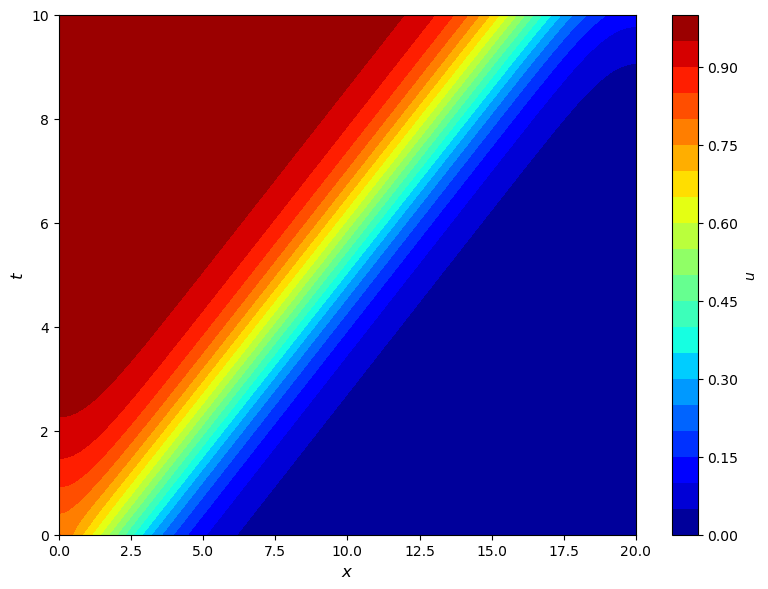

In [7]:
T=10; N=int(1e4); epsilon=1; a=20;
J=128; h=a/J; x=np.linspace(0,a,J+1)
u0=1/(1+np.exp(-(2-x)/sqrt(2)))
start=time.time()
[t,ut]=pde_fdm(u0,T,a,N,J,epsilon,fNagumo,'N')
end=time.time()
print("Elapsed time", end-start, "secs")
T, X = np.meshgrid(t, x)
#       
fig, ax = plt.subplots(figsize=(8, 6))
CS = ax.contourf(X, T, ut, levels=20, cmap='jet')
cbar = plt.colorbar(CS, ax=ax)
cbar.set_label(r'$u$', rotation=90) 
ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$t$', fontsize=12)
ax.set_title('', fontsize=14)
plt.tight_layout() 
plt.show()

In [8]:
fft=np.fft.fft
ifft=np.fft.ifft
def pde_oned_Gal(u0,T,a,N,J,epsilon,fhandle):
    """
    A3.5 Page 114
    """
    Dt=T/N; t=np.linspace(0,T,N+1); ut=np.zeros((J + 1,N + 1))
    # set linear operator 
    lam=(2 * pi/ a) * np.hstack([np.arange(0,J / 2+1), np.arange(- J / 2 + 1,0)]) 
    M=epsilon * lam ** 2
    EE=1.0 / (1 + Dt * M) # diagonal of (1+ Dt M)^{-1}
    ut[:,0]=u0;    u=u0[0:J];     uh=fft(u) # set initial condition
    #
    for n in range(0,N): # time loop
        fhu=fft(fhandle(u)) # evaluate fhat(u)
        uh_new=EE*(uh + Dt * fhu) # semi-implicit Euler step
        u=np.real(ifft(uh_new))
        ut[0:J,n + 1]=u
        uh=uh_new
    ut[J,:]=ut[0,:] # make periodic
    return t,ut

Elapsed time 0.03113722801208496 secs


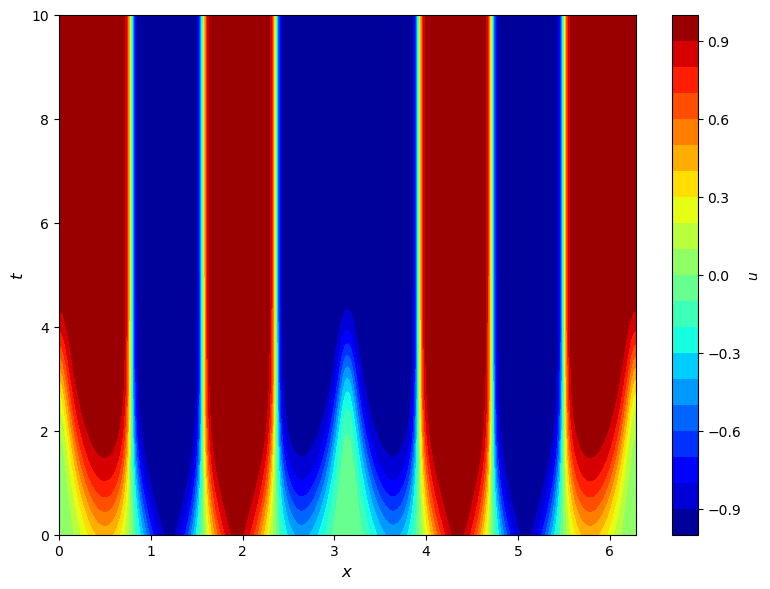

In [9]:
@vectorize([float64(float64)])
def fAC(u):
    return u-u**3
#
T=10;  N=1000;    a=2*pi;    J=512;    epsilon=1e-3
x=np.linspace(0,a,J+1);    u0=np.sin(4*x)*np.sin(x)
start=time.time()
[t,ut]=pde_oned_Gal(u0,T,a,N,J,epsilon,fAC)
end=time.time()
print("Elapsed time", end-start, "secs")
# Example
[T,X]=np.meshgrid(t,x)
fig, ax = plt.subplots(figsize=(8, 6))
CS = ax.contourf(X, T, ut, levels=20, cmap='jet')
cbar = plt.colorbar(CS, ax=ax)
cbar.set_label(r'$u$', rotation=90) 
ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$t$', fontsize=12)
ax.set_title('', fontsize=14)
plt.tight_layout() 
plt.show()

In [10]:
fft2=np.fft.fft2
ifft2=np.fft.ifft2
def pde_twod_Gal(u0,T,a,N,J,epsilon,fhandle):
    """
    A3.6 Page 116
    """
    Dt=T / N;    t=np.linspace(0,T,N+1);
    ut=np.zeros((J[0] + 1,J[1] + 1,N+1))
    # set linear operators
    lambdax=(2*pi/a[0]) * np.hstack([np.arange(0,J[0] / 2+1), np.arange(- J[0] / 2 + 1,0)])
    lambday=(2*pi/a[1]) * np.hstack([np.arange(0,J[1] / 2+1), np.arange(- J[1] / 2 + 1,0)])
    lambdaxx,lambdayy=np.meshgrid(lambdax,lambday,indexing='ij')
    M=epsilon * (lambdaxx ** 2 + lambdayy ** 2)
    EE=1.0 / (1 + Dt * M)
    ut[:,:,0]=u0;  u=u0[0:-1,0:-1];  uh=fft2(u)# set initial data 
    for n in range(N): # time loop
        fhu=fft2(fhandle(u)) # compute fhat
        uh_new=EE*(uh + Dt * fhu)
        u=np.real(ifft2(uh_new))
        ut[0:J[0],0:J[1],n + 1]=u
        uh=uh_new
    ut[J[0],:,:]=ut[0,:,:]
    ut[:,J[1] ,:]=ut[:,0,:] # make periodic
    return t,ut


In [11]:
T=10
N=int(1e3)
a=[2*pi,16]
J=[128,256]
epsilon=1e-3
x=np.linspace(0,a[0],J[0]+1); y=np.linspace(0,a[1],J[1]+1); 
[xx,yy]=np.meshgrid(x,y,indexing='ij')
u0=np.sin(yy)*np.cos(pi*xx/8)
start=time.time()
[t,ut]=pde_twod_Gal(u0,T,a,N,J,epsilon,fAC)
print(ut.shape)
end=time.time()
print("Run time", end-start, "secs")

(129, 257, 1001)
Run time 1.756089687347412 secs


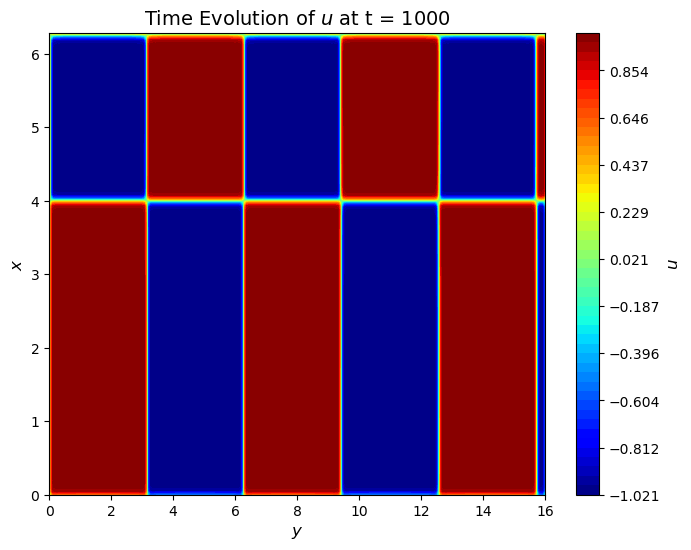

In [39]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(8, 6))
cmap = 'jet' 
levels = np.linspace(ut.min(), ut.max(), 50) 
contour = ax.contourf(yy, xx, ut[:, :, 0], levels=levels, cmap=cmap)
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label(r'$u$', fontsize=12)
ax.set_xlabel(r'$y$', fontsize=12)
ax.set_ylabel(r'$x$', fontsize=12)
ax.set_title('Time Evolution of $u$ at t = 0', fontsize=14)

def update(frame):
    ax.clear() 
    contour = ax.contourf(yy, xx, ut[:, :, frame], levels=levels, cmap=cmap)
    ax.set_xlabel(r'$y$', fontsize=12)
    ax.set_ylabel(r'$x$', fontsize=12)
    ax.set_title(f'Time Evolution of $u$ at t = {frame}', fontsize=14)
    return contour

ani = FuncAnimation(fig, update, frames=N + 1, interval=1000*T/(N + 1), blit=False)
ani.save('evolution.gif', writer=PillowWriter(fps=(N + 1) / T))
plt.show()


Reaction-Diffusion Equation

In [17]:
def oned_linear_FEM_b(ne,h,f):
    nvtx=ne + 1
    elt2vert=np.vstack([np.arange(0,ne,dtype='int'),
                        np.arange(1,(ne + 1),dtype='int')])
    bks=np.zeros((ne,2));    b=np.zeros(nvtx) 
    bks[:,0]=f[:-1]*(h / 3) + f[1:]*(h / 6)
    bks[:,1]=f[:-1]*(h / 6) + f[1:]*(h / 3)
    for row_no in range(0,2):
        nrow=elt2vert[row_no,:]
        b[nrow]=b[nrow]+bks[:,row_no]
    b=b[1:-1]
    return b

def pde_fem(u0,T,a,N,ne,epsilon,fhandle):
    h=a / ne;    nvtx=ne + 1;    Dt=T / N
    t=np.linspace(0,T,N+1)
    p=epsilon;    q=1;    f=1
    uh,A,b,KK,MM = Utils.FEM_Solver1D_r1(ne,p,q,f)
    EE=(MM + Dt * KK);    ZM=0
    # set initial condition
    ut=np.zeros((nvtx,N + 1));    ut[:,0]=u0;     u=np.copy(u0)
    EEinv=sparse.linalg.factorized(EE)
    for n in range(N):# time loop
        fu=fhandle(u)
        b=oned_linear_FEM_b(ne,h,fu)
        u_new=EEinv(MM.dot(u[1:-1]) + Dt * b)
        u=np.hstack([ZM,u_new,ZM])
        ut[:,n + 1]=u
    return t,ut

T=10;    N=int(1e4); a=1;    ne=512;    h=a/ne; epsilon=1e-3
x=np.linspace(0,a,ne+1)
u0=np.exp(-(x-0.5)**2/epsilon)
start=time.time()
[t,ut]=pde_fem(u0,T,a,N,ne,epsilon,fNagumo)
end=time.time()
print("Run time", end-start, "secs") 


Run time 0.9095690250396729 secs


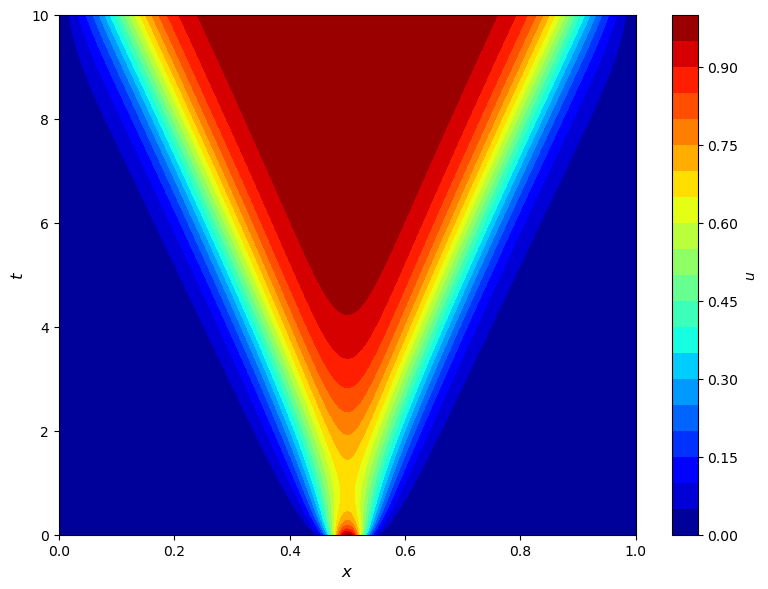

In [18]:
[T,X]=np.meshgrid(t,x)
fig, ax = plt.subplots(figsize=(8, 6))
CS = ax.contourf(X, T, ut, levels=20, cmap='jet')
cbar = plt.colorbar(CS, ax=ax)
cbar.set_label(r'$u$', rotation=90) 
ax.set_xlabel(r'$x$', fontsize=12)
ax.set_ylabel(r'$t$', fontsize=12)
ax.set_title('', fontsize=14)
plt.tight_layout() 
plt.show()